In [1]:
import MDAnalysis as mda
from numpy import *
import os
from pylab import *
import MDAnalysis.analysis.distances
import MDAnalysis.analysis.rms
from MDAnalysis.analysis import align
import glob
#import umap
import scipy.stats
import sklearn
import sklearn.decomposition
import sklearn.preprocessing
import mdtraj
import pandas as pd
import seaborn as sns
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

In [2]:
EQPOINT=250



h2opath="data/water/solvent_included/"
pegpath="data/peg/solvent_included/"

#glob tprs
h2ogros=sorted(glob.glob(h2opath+"*.gro"))
peggros=sorted(glob.glob(pegpath+"*.gro"))

#glob tprs
h2otprs=sorted(glob.glob(h2opath+"*.tpr"))
pegtprs=sorted(glob.glob(pegpath+"*.tpr"))

#trjs
h2otrjs=sorted(glob.glob(h2opath+"*.xtc"))
pegtrjs=sorted(glob.glob(pegpath+"*.xtc"))

systemtprs=[h2otprs,pegtprs]
systemtrjs=[h2otrjs,pegtrjs]



resids_proper=list(arange(-4,67))+list(arange(69,238))
resids=resids=list(arange(-4,67))+[nan,nan]+list(arange(69,238))

#get universes 
h2ou=[]
pegu=[]

for i in range(len(h2ogros)):
    h2ou.append(mda.Universe(h2otprs[i],h2otrjs[i]))
    #fix resids immediately
    h2ou[i].select_atoms("protein or resname CH6").residues.resids = resids_proper
for i in range(len(peggros)):
    pegu.append(mda.Universe(pegtprs[i],pegtrjs[i]))
    #fix resids immediately
    pegu[i].select_atoms("protein or resname CH6").residues.resids = resids_proper

#compile all the systems in one list
systems = [h2ou,pegu]
system_names = ['No-PEG','PEG']
#[]
#[tol-darkgreen,tol-darkblue,tol-bottompurple]
twoColour=["#332288","#882255"]
# Dark green,    
#sixColor=['#0A732D','#332288','#88CCEE',"#44AA99",'#882255','#D250BC']
#colorScheme=sixColor
colourScheme = twoColour
# Let's set up the selections for each trajectory by chain

# i want to make a list that has the sh2 domains selected in each sublist so that each one has 6 selections.
h2ou_fullprotein=[]
pegu_fullprotein=[]

h2ou_fullprotein_string=[]
pegu_fullprotein_string=[]


h2ou_notail=[]
pegu_notail=[]


h2ou_notail_string=[]
pegu_notail_string=[]


for i in range(len(h2otrjs)):
    h2ou_notail.append(h2ou[i].select_atoms("(protein or resname CH6) and resid 1:228"))
    h2ou_notail_string.append("(protein or resname CH6) and resid 1:228")
    h2ou_fullprotein.append(h2ou[i].select_atoms("(protein or resname CH6)"))
    h2ou_fullprotein_string.append("(protein or resname CH6)")
    
for i in range(len(pegtrjs)):
    pegu_notail.append(pegu[i].select_atoms("(protein or resname CH6) and resid 1:228"))
    pegu_notail_string.append("(protein or resname CH6) and resid 1:228")
    pegu_fullprotein.append(pegu[i].select_atoms("(protein or resname CH6)"))
    pegu_fullprotein_string.append("(protein or resname CH6)")

fullprotein_selections=[h2ou_fullprotein,pegu_fullprotein]
fullprotein_selections_string=[h2ou_fullprotein_string,pegu_fullprotein_string]
notail_selections = [h2ou_notail,pegu_notail]
notail_selections_string = [h2ou_notail_string,pegu_notail_string]



In [3]:
# Let's also come up with a more robust metric for beta-gap width

#Sarah suggested COM of a few residues in the strands
# Let's try it

beta_gap_distances_COM=[]

for i in range(len(systems)):
    sub=[]
    for j in range(len(systems[i])):
        tu = systems[i][j]

        d_trajectory=[]
        for ts in range(len(tu.trajectory)):
            tu.trajectory[ts]
            r1 = tu.select_atoms("resid 144:146 and name CA").center_of_geometry()
            r2 = tu.select_atoms("resid 197:199 and name CA").center_of_geometry()

            deltaR= r2 - r1
            d = sqrt(dot(deltaR,deltaR))
            d_trajectory.append(d)
        sub.append(d_trajectory)
    beta_gap_distances_COM.append(sub)




In [4]:
def HistMonster(dataSplit,dataRange):
    
    nSplit=len(dataSplit)
    histMonster=[]

    for i in range(len(dataSplit)):
        temp=[]
        for j in range(len(dataSplit[i])):
            temp.append(hist(dataSplit[i][j],dataRange,density = True)[0])
        histMonster.append(temp)
    cla()
    close()
    histMeans=[]
    histSters=[]

    for i in range(len(histMonster)):
        histMeans.append(mean(histMonster[i],axis = 0))
        histSters.append(scipy.stats.sem(histMonster[i],axis = 0))
        
    return histMeans, histSters


beta_gap_eq_array_COM = array(beta_gap_distances_COM).T[EQPOINT:].T
beta_gap_flat_split_COM = [beta_gap_eq_array_COM[0],beta_gap_eq_array_COM[1]]

betagap_mean_hists_COM,betagap_ster_hists_COM = HistMonster(beta_gap_flat_split_COM,arange(4,13,0.1))


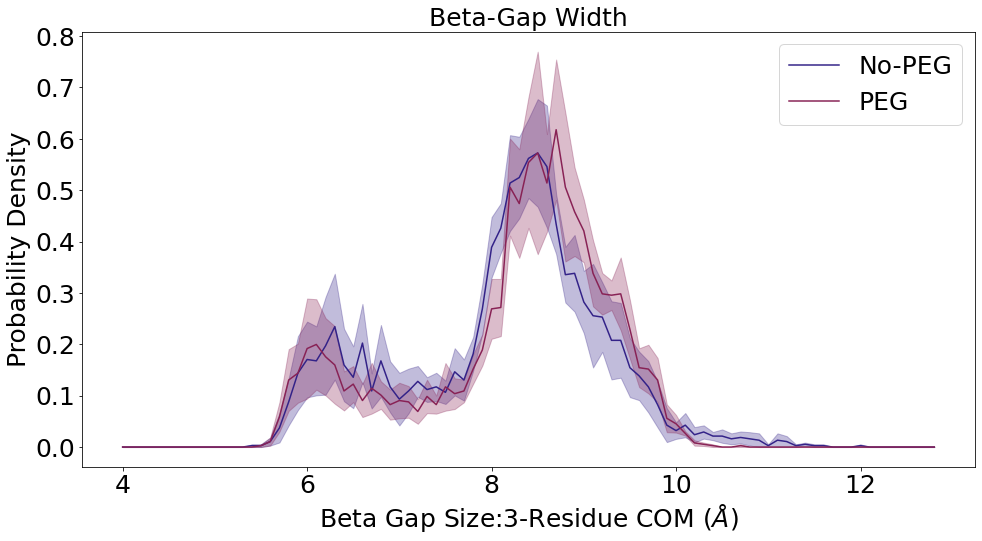

In [8]:
figure(figsize = (16,8))
plot(arange(4,13,0.1)[:-1],betagap_mean_hists_COM[0],color = colourScheme[0],label = system_names[0])
plot(arange(4,13,0.1)[:-1],betagap_mean_hists_COM[1],color = colourScheme[1],label = system_names[1])


fill_between(arange(4,13,0.1)[:-1], betagap_mean_hists_COM[0] - betagap_ster_hists_COM[0],betagap_mean_hists_COM[0] + betagap_ster_hists_COM[0],color = colourScheme[0],alpha = 0.3)
fill_between(arange(4,13,0.1)[:-1], betagap_mean_hists_COM[1] - betagap_ster_hists_COM[1],betagap_mean_hists_COM[1] + betagap_ster_hists_COM[1],color = colourScheme[1],alpha = 0.3)


xlabel("Beta Gap Size:3-Residue COM ($\AA$)",fontsize = 25)
ylabel("Probability Density",fontsize = 25)
title("Beta-Gap Width",fontsize = 25)
xticks(fontsize = 25)
yticks(fontsize = 25)

legend(fontsize = 25)



#savefig("BetaGapWidth_3resCOM.png",dpi = 600)

In [6]:
save("betaGapMeanHists.npy",betagap_mean_hists_COM)
save("betaGapSterHists.npy",betagap_ster_hists_COM)